In [47]:
import sqlite3 as sqlt
import pandas as pd
from datetime import datetime
import dateutil.relativedelta as oper_date
import io
import requests as req
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
%matplotlib inline
sns.set(style="white", color_codes=True)

In [2]:
querie = """select * from exports where "Cod. Mun" in {} and 
"NCM" like "6402%";"""
grendene_cidades = "(4307906, 4304804,  2312908, 2931350, 2304202, 2304400)"
alpargatas_cidades = "(2604007, 2504009, 3143302, 3530607)"


In [3]:
con = sqlt.connect("big_data2.db")
cursor = con.cursor()

In [4]:
def get_datetime(string):
    mes, ano = string.split("T")
    ano = "20" + ano
    dict_mes = {"1":3, "2":6, "3":9, "4":12}
    return datetime(int(ano), dict_mes[mes], 1)

def data_clean_db(dataframe):
    dict_nomes_colunas = {"month":"data","US$ de P1":"financeiro","Desc. Mun":"municipio",
                          "Kg Liq de P1":"peso","Qtd de P1":"quantidade"}
    dataframe.rename(columns=dict_nomes_colunas,inplace=True)
    dataframe.drop(axis=1,columns=['Cod. Mun', 'municipio', 'NCM', "Desc. NCM"],inplace=True)
    dataframe.data = dataframe.data.apply(
        lambda data: datetime.strptime(data.split()[0], "%Y-%m-%d"))
    dataframe.set_index("index", inplace=True)
    dataframe.financeiro = dataframe.financeiro.astype("int")
    dataframe.peso = dataframe.peso.astype("int") 
    
    return dataframe

def get_meses_por_trimestres(db):
    anos = list(range(2003,2018))
    trimestres = [3, 6, 9, 12]
    balanco_mensal = pd.DataFrame(columns=
        ["1M_quantidade","2M_quantidade","3M_quantidade",
            "acumulado_quantidade","acumulado_peso", "acumulado_financeiro" ,"trimestre"])
    #balanco_mensal = pd.DataFrame(columns=
     #       ["1M_quantidade","2M_quantidade","3M_quantidade",
      #      "acumulado_quantidade","trimestre"])
    mes3 = (lambda exportacao: exportacao[2] if len(exportacao) == 3 else 0)
    for ano in anos:
        for trimestre in trimestres:
            trimestre_ = datetime(ano, trimestre, 1)
            tabela_trimestral = db[(db.data <= trimestre_) & 
                      (db.data > trimestre_ - oper_date.relativedelta(months=3))]
            quantidade_trimestral = tabela_trimestral.groupby("data").quantidade.sum()
            balanco_mensal = balanco_mensal.append(
                    {"1M_quantidade": quantidade_trimestral[0],
                    "2M_quantidade": quantidade_trimestral[1],
                     "3M_quantidade": mes3(quantidade_trimestral),
                     "acumulado_quantidade": quantidade_trimestral.sum(),
                     "acumulado_peso": tabela_trimestral.peso.sum(),
                    "acumulado_financeiro": tabela_trimestral.financeiro.sum(),
                     "trimestre": trimestre_
                    }, ignore_index=True)  
    balanco_mensal.set_index("trimestre",inplace=True)
    balanco_mensal.iloc[:,0:7] = balanco_mensal.iloc[:,0:7].astype("int")
    return balanco_mensal

In [5]:
grendene_db = pd.read_sql_query(querie.format(grendene_cidades), con)
alpargatas_db = pd.read_sql_query(querie.format(alpargatas_cidades), con)

grendene_db = data_clean_db(grendene_db)
alpargatas_db = data_clean_db(alpargatas_db)

In [6]:
balanco_mensal_gren = get_meses_por_trimestres(grendene_db)
balanco_mensal_alp = get_meses_por_trimestres(alpargatas_db)

In [7]:
balanco_mensal_alp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2003-03-01 to 2017-12-01
Data columns (total 6 columns):
1M_quantidade           60 non-null int64
2M_quantidade           60 non-null int64
3M_quantidade           60 non-null int64
acumulado_quantidade    60 non-null int64
acumulado_peso          60 non-null int64
acumulado_financeiro    60 non-null int64
dtypes: int64(6)
memory usage: 3.3 KB


In [8]:
balanco_trimestral_alp = pd.read_excel("Exportação calçados.xlsx")
balanco_trimestral_alp = balanco_trimestral_alp[
    ["Unnamed: 2","Volume exportado Alpargatas"]]
balanco_trimestral_alp.rename(columns={
    "Unnamed: 2":"trimestre","Volume exportado Alpargatas":"exportado"},inplace=True)
balanco_trimestral_alp.trimestre = balanco_trimestral_alp.trimestre.apply(
    lambda data:data.date())
balanco_trimestral_alp.dropna(inplace=True)
balanco_trimestral_alp.exportado = balanco_trimestral_alp.exportado.astype("int")
balanco_trimestral_alp.reset_index(inplace=True)  
balanco_trimestral_alp.drop(columns="index",inplace=True)
balanco_trimestral_alp.set_index("trimestre",inplace=True)
balanco_trimestral_alp.head(4)

,exportado
trimestre,
2010-03-01,6500000
2010-06-01,7500000
2010-09-01,6100000
2010-12-01,6100000


In [9]:
url = "http://ri.grendene.com.br/Arquivos/Grendene_Informacoes_Financeiras_Download.xls"
balanco_trimestral_gren = pd.read_excel(url, encoding="latin-1",sheet_name="Volumes")
balanco_trimestral_gren.head(5)

,Grendene S.A.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90
NaN,Em milhares de pares,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,Volume de pares - Calçados,2006.0,1T07,2T07,1S07,3T07,9M07,4T07,2S07,2007.0,...,2016.0,1T17,2T17,1S17,3T17,9M17,4T17,2S17,2017.0,1T18
NaN,Mercado interno,100421.0,18501,18894,37395,30228,67623,37900,68128,105523.0,...,123595.0,26844,24133,50977,36448,87425,38950,75398,126375.0,29451
NaN,Exportação,31503.0,13152,6324,19476,7609,27085,12975,20584,40060.0,...,39962.0,11016,9228,20244,8733,28977,15994,24727,44971.0,10991


In [10]:
balanco_trimestral_gren.drop(columns="Grendene S.A.",inplace=True)
balanco_trimestral_gren = pd.DataFrame({"trimestre":balanco_trimestral_gren.iloc[2],
                                  "total_exportado":balanco_trimestral_gren.iloc[4]})
balanco_trimestral_gren.head(4)

,trimestre,total_exportado
Unnamed: 1,2006,31503
Unnamed: 2,1T07,13152
Unnamed: 3,2T07,6324
Unnamed: 4,1S07,19476


In [11]:
balanco_trimestral_gren.reset_index(inplace=True)
balanco_trimestral_gren.drop(axis=1,columns=["index"],inplace=True)
balanco_trimestral_gren.head(8)

,trimestre,total_exportado
0,2006,31503
1,1T07,13152
2,2T07,6324
3,1S07,19476
4,3T07,7609
5,9M07,27085
6,4T07,12975
7,2S07,20584


In [12]:
balanco_trimestral_gren = balanco_trimestral_gren[
                        balanco_trimestral_gren.trimestre.str[1] == "T"]
balanco_trimestral_gren.head(8)

,trimestre,total_exportado
1,1T07,13152
2,2T07,6324
4,3T07,7609
6,4T07,12975
9,1T08,18631
10,2T08,6786
12,3T08,9142
14,4T08,13285


In [13]:
balanco_trimestral_gren.trimestre = balanco_trimestral_gren.trimestre.apply(
    lambda string:get_datetime(string))
balanco_trimestral_gren.head(4)

,trimestre,total_exportado
1,2007-03-01,13152
2,2007-06-01,6324
4,2007-09-01,7609
6,2007-12-01,12975


In [14]:
balanco_trimestral_gren.total_exportado = balanco_trimestral_gren.total_exportado.apply(
    lambda exportacao:exportacao*1000)
balanco_trimestral_gren.set_index("trimestre",inplace=True)
balanco_trimestral_gren.head(4)

,total_exportado
trimestre,
2007-03-01,13152000
2007-06-01,6324000
2007-09-01,7609000
2007-12-01,12975000


In [15]:
balanco_mensal_gren.info()
print("###########################################")
balanco_trimestral_gren.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2003-03-01 to 2017-12-01
Data columns (total 6 columns):
1M_quantidade           60 non-null int64
2M_quantidade           60 non-null int64
3M_quantidade           60 non-null int64
acumulado_quantidade    60 non-null int64
acumulado_peso          60 non-null int64
acumulado_financeiro    60 non-null int64
dtypes: int64(6)
memory usage: 3.3 KB
###########################################
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 2007-03-01 to 2018-03-01
Data columns (total 1 columns):
total_exportado    45 non-null int64
dtypes: int64(1)
memory usage: 720.0 bytes


In [16]:
balanco_mensal_gren.head(5)

,1M_quantidade,2M_quantidade,3M_quantidade,acumulado_quantidade,acumulado_peso,acumulado_financeiro
trimestre,,,,,,
2003-03-01,2917687,2990283,2452614,8360584,3397023,18733681
2003-06-01,2197177,1767084,661129,4625390,1880988,11151631
2003-09-01,1046892,1678653,0,2725545,1077171,7352300
2003-12-01,1970830,1059055,2594101,5623986,2305773,12680141
2004-03-01,3633704,3999037,3650149,11282890,4631776,26378763


In [17]:
balanco_mensal_gren = balanco_mensal_gren.iloc[16:]
balanco_mensal_gren.head(3)

,1M_quantidade,2M_quantidade,3M_quantidade,acumulado_quantidade,acumulado_peso,acumulado_financeiro
trimestre,,,,,,
2007-03-01,3888139,5055361,3026261,11969761,4036796,29310388
2007-06-01,3128807,1553287,1835429,6517523,2179512,15838562
2007-09-01,2249176,3272847,2780883,8302906,2891570,21504020


In [18]:
balanco_trimestral_gren = balanco_trimestral_gren.iloc[:-1,]

In [19]:
balanco_mensal_gren.info()
print("###########################################")
balanco_trimestral_gren.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2007-03-01 to 2017-12-01
Data columns (total 6 columns):
1M_quantidade           44 non-null int64
2M_quantidade           44 non-null int64
3M_quantidade           44 non-null int64
acumulado_quantidade    44 non-null int64
acumulado_peso          44 non-null int64
acumulado_financeiro    44 non-null int64
dtypes: int64(6)
memory usage: 2.4 KB
###########################################
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44 entries, 2007-03-01 to 2017-12-01
Data columns (total 1 columns):
total_exportado    44 non-null int64
dtypes: int64(1)
memory usage: 704.0 bytes


In [20]:
relacao_mensal_trimestral_gren = balanco_mensal_gren.copy()
relacao_mensal_trimestral_gren["quantidade_anunciada_trimestre"] = balanco_trimestral_gren

In [21]:
relacao_mensal_trimestral_gren.head(4)

,1M_quantidade,2M_quantidade,3M_quantidade,acumulado_quantidade,acumulado_peso,acumulado_financeiro,quantidade_anunciada_trimestre
trimestre,,,,,,,
2007-03-01,3888139,5055361,3026261,11969761,4036796,29310388,13152000
2007-06-01,3128807,1553287,1835429,6517523,2179512,15838562,6324000
2007-09-01,2249176,3272847,2780883,8302906,2891570,21504020,7609000
2007-12-01,2444514,3174633,2863572,8482719,2835016,21524805,12975000


In [22]:
balanco_mensal_alp.info()
print("##########################")
balanco_trimestral_alp.info()
balanco_mensal_alp = balanco_mensal_alp.iloc[28:]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2003-03-01 to 2017-12-01
Data columns (total 6 columns):
1M_quantidade           60 non-null int64
2M_quantidade           60 non-null int64
3M_quantidade           60 non-null int64
acumulado_quantidade    60 non-null int64
acumulado_peso          60 non-null int64
acumulado_financeiro    60 non-null int64
dtypes: int64(6)
memory usage: 3.3 KB
##########################
<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 2010-03-01 to 2017-12-01
Data columns (total 1 columns):
exportado    32 non-null int64
dtypes: int64(1)
memory usage: 512.0+ bytes


In [23]:
balanco_mensal_alp.info()
print("##########################")
balanco_trimestral_alp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32 entries, 2010-03-01 to 2017-12-01
Data columns (total 6 columns):
1M_quantidade           32 non-null int64
2M_quantidade           32 non-null int64
3M_quantidade           32 non-null int64
acumulado_quantidade    32 non-null int64
acumulado_peso          32 non-null int64
acumulado_financeiro    32 non-null int64
dtypes: int64(6)
memory usage: 1.8 KB
##########################
<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 2010-03-01 to 2017-12-01
Data columns (total 1 columns):
exportado    32 non-null int64
dtypes: int64(1)
memory usage: 512.0+ bytes


In [24]:
relacao_mensal_trimestral_alp = balanco_mensal_alp.copy()
relacao_mensal_trimestral_alp["quantidade_anunciada_trimestre"] = balanco_trimestral_alp

In [25]:
balanco_mensal_gren

,1M_quantidade,2M_quantidade,3M_quantidade,acumulado_quantidade,acumulado_peso,acumulado_financeiro
trimestre,,,,,,
2007-03-01,3888139,5055361,3026261,11969761,4036796,29310388
2007-06-01,3128807,1553287,1835429,6517523,2179512,15838562
2007-09-01,2249176,3272847,2780883,8302906,2891570,21504020
2007-12-01,2444514,3174633,2863572,8482719,2835016,21524805
2008-03-01,8102110,6321099,4755067,19178276,6626025,46384405
2008-06-01,2850212,2004656,1890066,6744934,2292001,18500029
2008-09-01,2669581,3223286,4513222,10406089,3683541,33335444
2008-12-01,2770032,2386557,5822909,10979498,3694817,33059032
2009-03-01,5202739,6500850,4264563,15968152,5538324,46818870


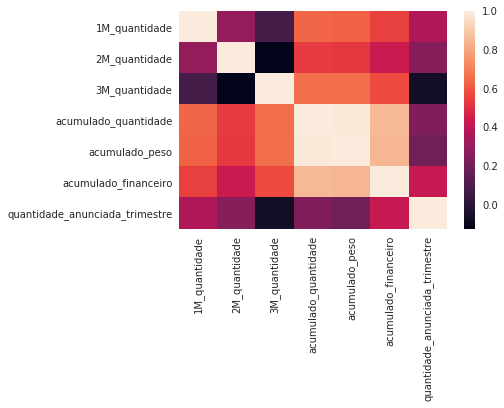

In [26]:
sns.heatmap(relacao_mensal_trimestral_alp.corr())

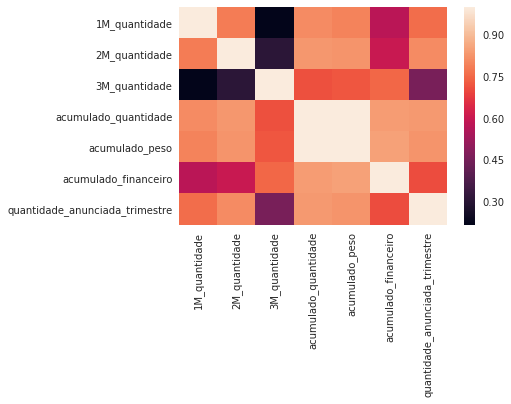

In [27]:
sns.heatmap(relacao_mensal_trimestral_gren.corr())

/home/rafa/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/rafa/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


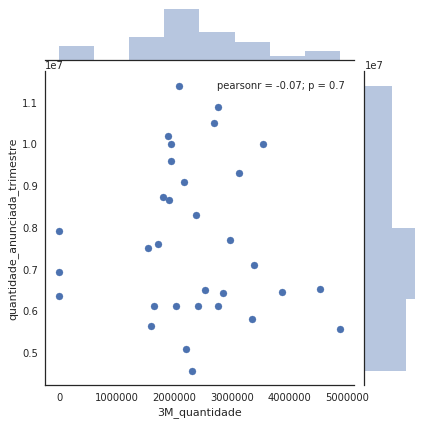

In [28]:
sns.jointplot(x="3M_quantidade",y="quantidade_anunciada_trimestre",
              data=relacao_mensal_trimestral_alp,kind='scatter')

/home/rafa/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/rafa/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


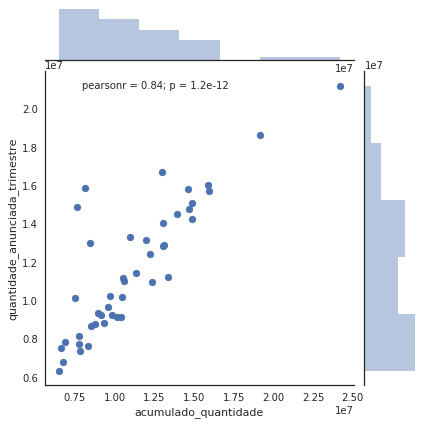

In [29]:
sns.jointplot(x="acumulado_quantidade",y="quantidade_anunciada_trimestre",
              data=relacao_mensal_trimestral_gren,kind='scatter')

In [30]:
relacao_mensal_trimestral_gren.quantidade_anunciada_trimestre.std()

3452187.6915692766

In [31]:
relacao_mensal_trimestral_gren.quantidade_anunciada_trimestre.mean()

11642659.090909092

AxesSubplot(0.125,0.125;0.775x0.755)


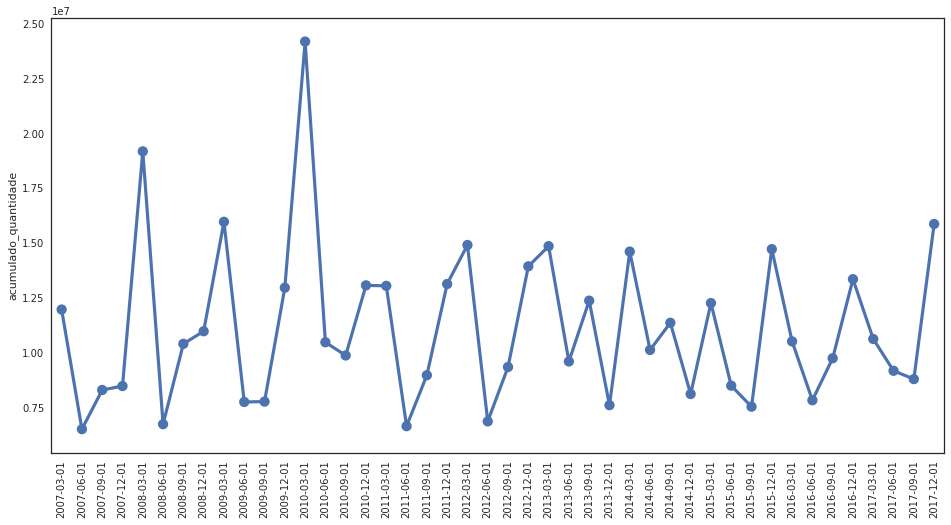

In [32]:
plt.figure(figsize=(16,8))
graph = sns.pointplot(x=relacao_mensal_trimestral_gren.index.date, 
              y=relacao_mensal_trimestral_gren.acumulado_quantidade)
plt.setp(graph.get_xticklabels(), rotation=90)
print(graph)

marco, (fev,abril), (jan, mai), (dez,jun)

AxesSubplot(0.125,0.125;0.775x0.755)


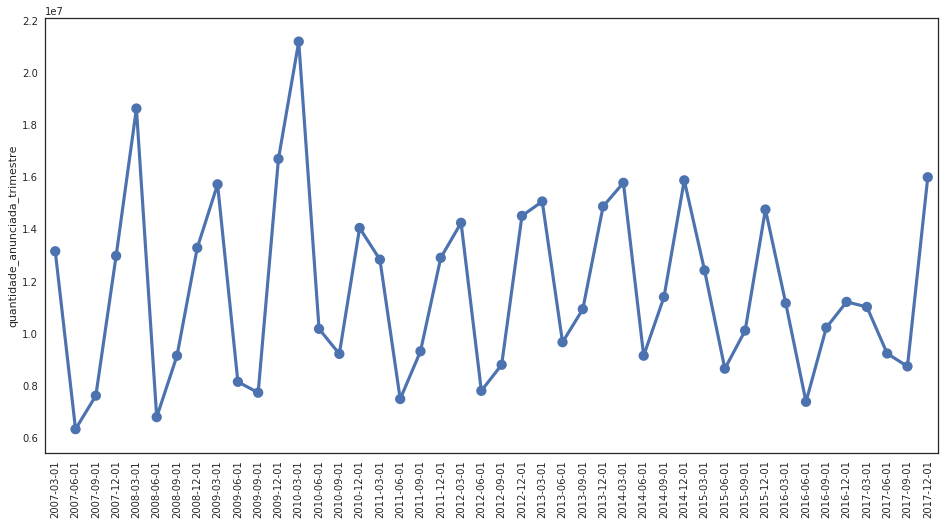

In [33]:
plt.figure(figsize=(16,8))
graph = sns.pointplot(x=relacao_mensal_trimestral_gren.index.date, 
              y=relacao_mensal_trimestral_gren.quantidade_anunciada_trimestre)
plt.setp(graph.get_xticklabels(), rotation=90)
print(graph)

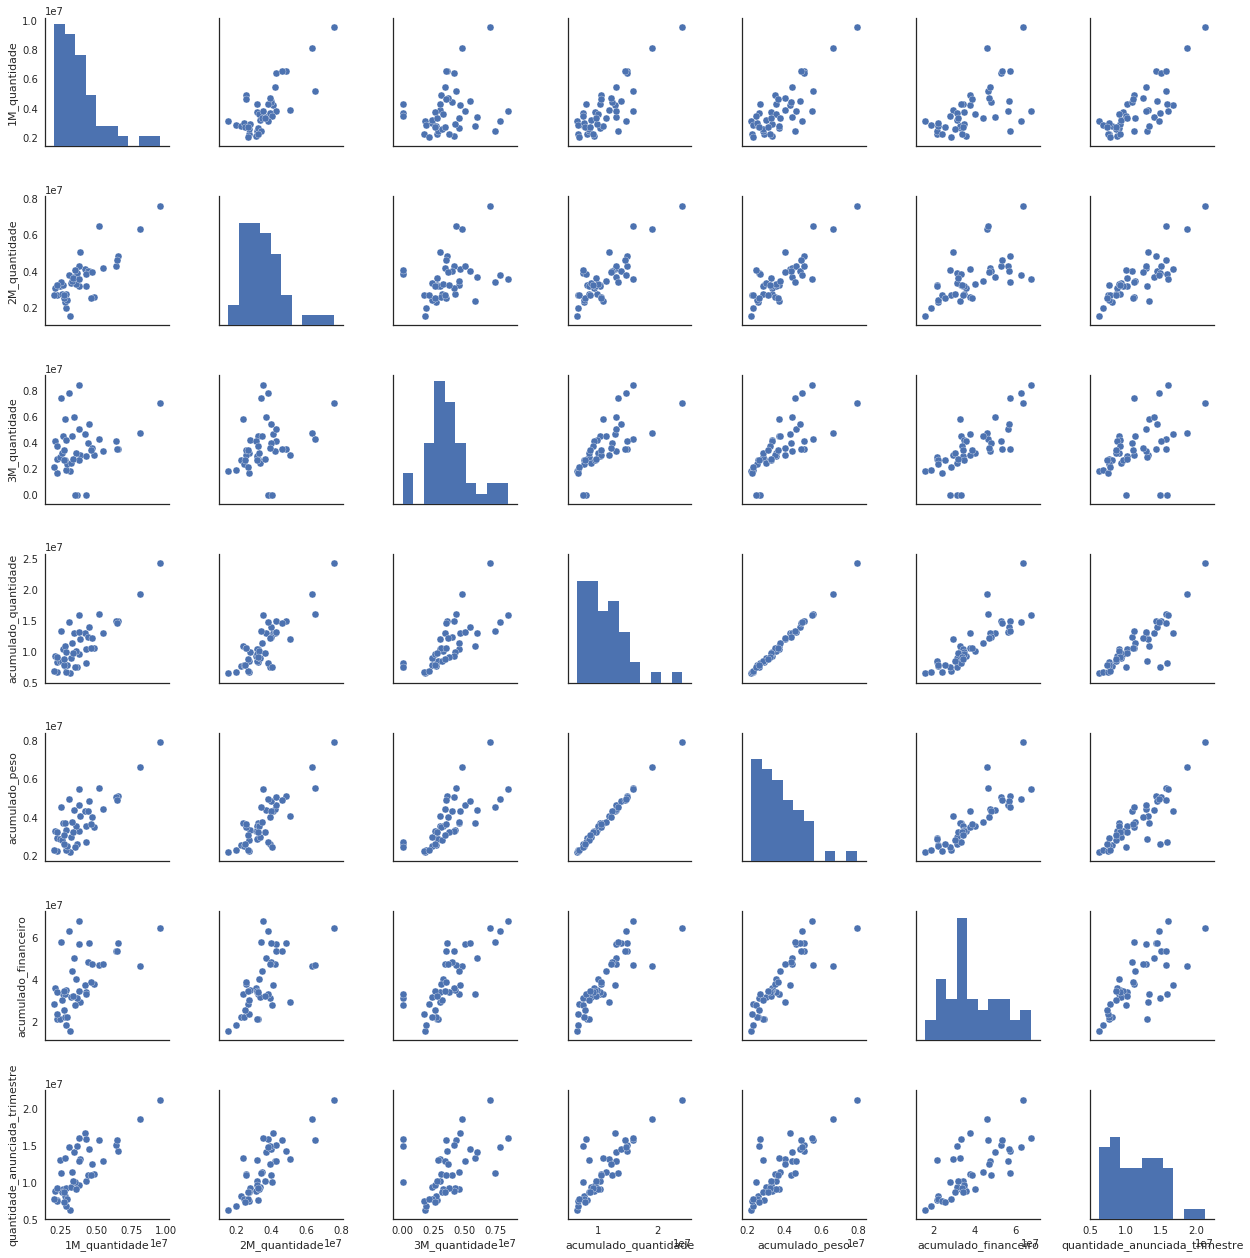

In [34]:
sns.pairplot(relacao_mensal_trimestral_gren)

AxesSubplot(0.125,0.125;0.775x0.755)


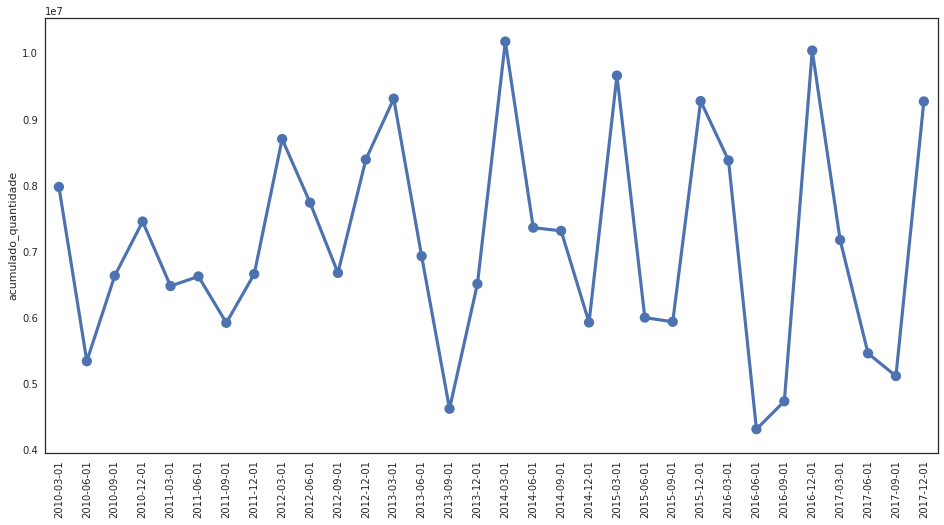

In [35]:
plt.figure(figsize=(16,8))
graph = sns.pointplot(x=relacao_mensal_trimestral_alp.index.date, 
              y=relacao_mensal_trimestral_alp.acumulado_quantidade)
plt.setp(graph.get_xticklabels(), rotation=90)
print(graph)

AxesSubplot(0.125,0.125;0.775x0.755)


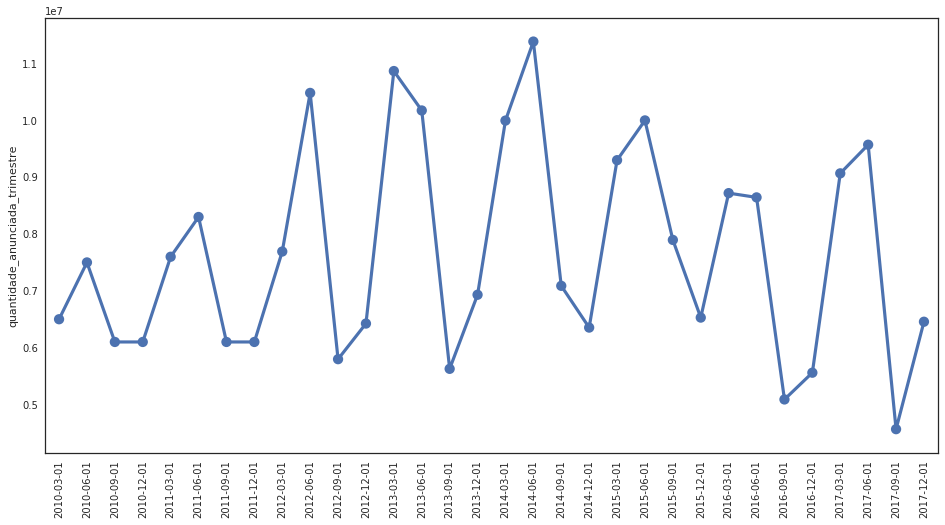

In [36]:
plt.figure(figsize=(16,8))
graph = sns.pointplot(x=relacao_mensal_trimestral_alp.index.date, 
              y=relacao_mensal_trimestral_alp.quantidade_anunciada_trimestre)
plt.setp(graph.get_xticklabels(), rotation=90)
print(graph)

In [37]:
balanco_mensal_gren.head(3)

,1M_quantidade,2M_quantidade,3M_quantidade,acumulado_quantidade,acumulado_peso,acumulado_financeiro
trimestre,,,,,,
2007-03-01,3888139,5055361,3026261,11969761,4036796,29310388
2007-06-01,3128807,1553287,1835429,6517523,2179512,15838562
2007-09-01,2249176,3272847,2780883,8302906,2891570,21504020


In [51]:
a = balanco_mensal_gren

In [39]:
#x_train, x_test, y_train, y_test = train_test_split(a, balanco_trimestral_gren,
#                                                   test_size=0.2)

In [64]:
lm = LinearRegression()

In [65]:
x_train = balanco_mensal_gren.iloc[:35]
x_test = balanco_mensal_gren.iloc[35:]
y_train = balanco_trimestral_gren.iloc[:35]
y_test = balanco_trimestral_gren.iloc[35:]

In [66]:
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [67]:
coeff_df = pd.DataFrame(lm.coef_[0],x_train.columns,columns=['Coefficient'])
coeff_df

,Coefficient
1M_quantidade,0.217340
2M_quantidade,1.338555
3M_quantidade,-0.083698
acumulado_quantidade,1.472197
acumulado_peso,-3.706198
acumulado_financeiro,0.042455


/home/rafa/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


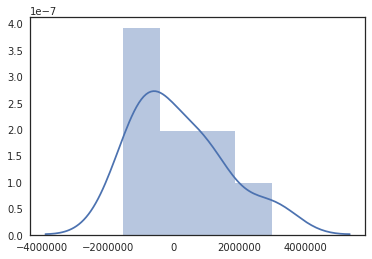

In [72]:
predictions = lm.predict(x_test)
sns.distplot(y_test-predictions)

In [69]:
data = [[previsto[0], realizado] for previsto, realizado in zip(predictions,y_test.total_exportado)]

In [70]:
df = pd.DataFrame(columns=["Previsto","Realizado"], 
                                data=data)
df = df.set_index(y_test.index)
a = df.transpose()

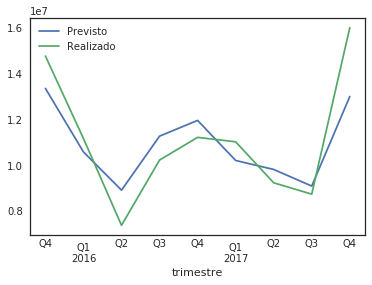

In [71]:
a.T.plot()